##### **Author(s)**:  Zareef Jafar, Anowar J. Shajib

In [1]:
import time

import h5py
import joblib
import matplotlib.pyplot as plt

# import of standard python libraries
import numpy as np
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Util import mask_util, util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

%matplotlib inline

## Load imaging data

The data and the PSF needs to be provided to `lenstronomy` using the
dictionaries `kwargs_data` and `kwargs_psf`.

In `kwargs_data`, we also need to proivde information on the noise level.
Either the pixel-wise noise map can be provided using the `noise_map`
keyword, or simply the `exposure_time` and `background_rms` can be provided
for `lenstronomy` to create the noise map by itself.

The keywords `ra_at_xy_0` and `dec_at_xy_0` are the RA and Declination in
arcsecond units at the (0, 0) pixel. The keyword `transform_pix2angle` is
the transformation matrix from pixel number coordinates to (RA, Decl.).
These keywords are used to convert pixel coordinates to RA and Decl.
coordinates. If you want to convert one 2D coordinate system to another, you
 will need to the offset between the zeropoints of two coordinate systems
 and transformation matrix that specifies the scaling and rotation of the
 axes. So, the keywords `ra_at_xy_0` and `dec_at_xy_0` specify the zeropoint
  offsets, and `transform_pix2angle` is the tansformation matrix specifying
  scaling and rotation.

For the first example of lensing data, no PSF was used to create the data.
Therefore, `psf_type` is set to `NONE`. For real data, there has to be a PSF
. We will work with PSFs in later examples.

In [2]:
with h5py.File("./DESIJ1554+0443/DESIJ1554+0443_F140W.h5", "r") as f:
    kwargs_data = {}
    for key in f:
        kwargs_data[key] = f[key][()]


# load HDF5 psf file using h5py
with h5py.File("./DESIJ1554+0443/psf_F140W.h5", "r") as f:
    kwargs_psf = {}
    for key in f:
        kwargs_psf[key] = f[key][()]
kwargs_psf["psf_type"] = "PIXEL"

kwargs_data

{'background_rms': 0.0137866616807371,
 'dec_at_xy_0': -4.839999999999995,
 'exposure_time': array([[526.58203, 420.42545, 478.3544 , ..., 533.4616 , 399.34912,
         517.8962 ],
        [424.4987 , 484.88034, 551.4943 , ..., 489.48572, 418.86212,
         522.29926],
        [384.8858 , 505.07867, 419.24973, ..., 487.39197, 435.3952 ,
         508.632  ],
        ...,
        [498.08844, 443.47632, 427.97556, ..., 498.2728 , 343.41418,
         507.6376 ],
        [427.0364 , 436.4274 , 502.66687, ..., 506.71988, 465.6584 ,
         510.76175],
        [410.01215, 504.86472, 437.02142, ..., 376.98816, 511.93005,
         502.43845]], dtype=float32),
 'image_data': array([[ 0.01204894,  0.00179044,  0.0021683 , ..., -0.01431787,
          0.01175164, -0.00076203],
        [ 0.00971342,  0.00726407,  0.00480296, ..., -0.00116851,
         -0.00183223, -0.01219291],
        [-0.00765296, -0.00050401,  0.00288014, ..., -0.02108379,
         -0.02647783, -0.01446793],
        ...,
     

/tmp/ipykernel_6972/3612032868.py:1: RuntimeWarning: invalid value encountered in log10
  plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


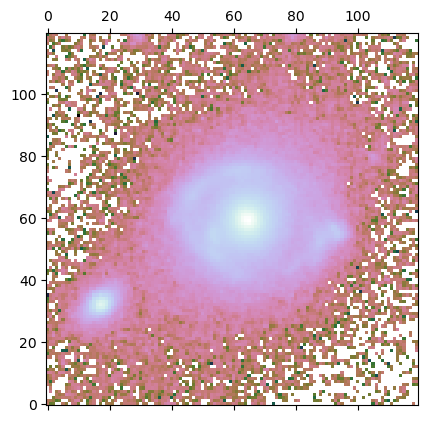

In [3]:
plt.matshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")

In [4]:
# To make a mask using lenstronomy functions, here is an example code:


ra_at_xy_0 = kwargs_data["ra_at_xy_0"]
dec_at_xy_0 = kwargs_data["dec_at_xy_0"]
transform_pix2angle = kwargs_data["transform_pix2angle"]

coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
num_pix = len(kwargs_data["image_data"])

x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)

r1 = 5  # arcsecond
r2 = 2.5
lens_center_ra = 0
lens_center_dec = 0

mask_outer_1 = mask_util.mask_center_2d(
    lens_center_ra,
    lens_center_dec,
    r1,
    util.image2array(x_coords),
    util.image2array(y_coords),
)


mask_ext_1 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra + 3.5,
    lens_center_dec - 2.2,
    1,
    1,
    0,
)

mask_ext_2 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 3.5,
    lens_center_dec + 1.7,
    0.5,
    0.5,
    0,
)


mask_ext_3 = mask_util.mask_ellipse(
    util.image2array(x_coords),
    util.image2array(y_coords),
    lens_center_ra - 2.7,
    lens_center_dec - 0.4,
    0.3,
    0.3,
    0,
)

mask = (1 - mask_outer_1) * (1 - mask_ext_1) * (1 - mask_ext_2)
mask[mask >= 1] = 1
mask[mask < 0] = 0


mask_img = mask.reshape(num_pix, num_pix)

## Applying mask

/tmp/ipykernel_6972/4187877492.py:3: RuntimeWarning: invalid value encountered in log10
  ori = np.log10(kwargs_data["image_data"])
/tmp/ipykernel_6972/4187877492.py:5: RuntimeWarning: divide by zero encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_6972/4187877492.py:5: RuntimeWarning: invalid value encountered in log10
  masked_img = np.log10(kwargs_data["image_data"] * mask_img)
/tmp/ipykernel_6972/4187877492.py:8: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")


Text(0.5, 1.0, 'Masked image')

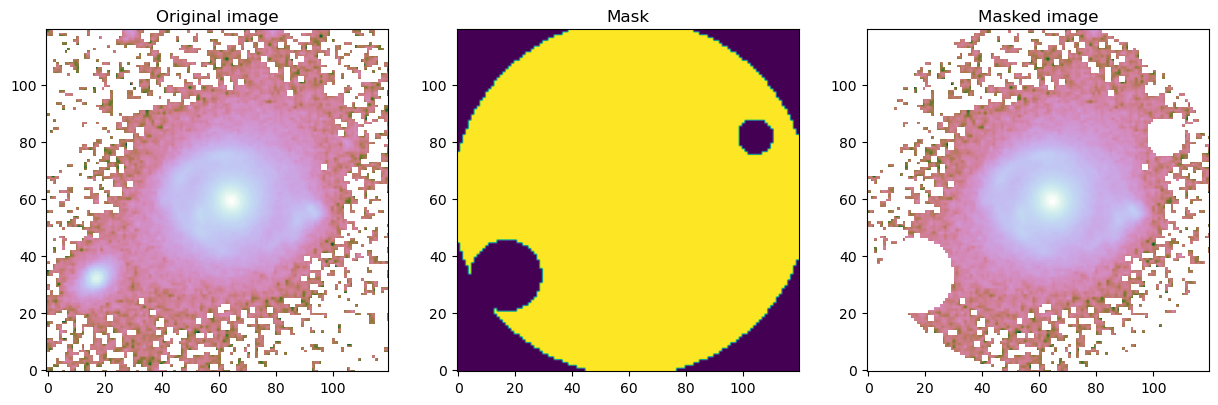

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15, 10))

ori = np.log10(kwargs_data["image_data"])

masked_img = np.log10(kwargs_data["image_data"] * mask_img)

plt.sca(axs[0])
plt.imshow(np.log10(kwargs_data["image_data"]), origin="lower", cmap="cubehelix")
plt.title("Original image")

plt.sca(axs[1])
plt.imshow(mask_img, origin="lower")
plt.title("Mask")

plt.sca(axs[2])
plt.imshow(masked_img, origin="lower", cmap="cubehelix")
plt.title("Masked image")

In [6]:
print("Mask dimension:", mask_img.shape, "\nMask type: ", type(mask_img))

Mask dimension: (120, 120) 
Mask type:  <class 'numpy.ndarray'>


## Building a lens model

Here, we build a lens model. The lens model can be thought of three
components: the lens galaxy's mass model, the lens galaxy's light model, and
the source galaxy's light model. We have to give a list of profiles for each
 component as shown in the next codecell.

The `'EPL'` lens mass profile stands for Elliptical Power Law. The form of
this convergence profile is given by:
$$\kappa(x, y) = \frac{3 - \gamma}{2} \left[ \frac{\theta_{\rm E}}{\sqrt{q
x^2 + y^2 / q}} \right]^{\gamma - 1}. $$

The position angle $\phi$ adjusts the orientation of the mass profile's
major axis. The ellipticity parameters $q$ and $\phi$ can be reformulated as
$$e_1 = \frac{1 - q}{1 + q} \cos 2\phi,$$
$$e_2 = \frac{1 - q}{1 + q} \sin 2\phi.$$

`lenstronomy` uses $e_1$ and $e_2$ instead of $q$ and $\phi$, because $e_1$
and $e_2$ are easier to handle in numerical optimization, for example, in
MCMC. You can check [here](https://github.com/lenstronomy/lenstronomy-tutorials/blob/main/Notebooks/GettingStarted/units_coordinates_parameters_definitions.ipynb) for more details on
parameter definitions and conventions used in `lenstronomy`.


Both the lens galaxy's and the source galaxy's light profiles are modeled
with Sersic function, which is given by:

$$I(x, y) = I_{\rm e} \exp \left[ -b_{n} \left\{ \left( \frac{\sqrt{q x^2
+ y^2/q}}{R_{\rm Sersic}} \right)^{1/n_{\rm Sersic}} - 1 \right\}
\right].$$

In [18]:
lens_model_list = ["EPL", "SHEAR"]


# beta, n_max, center_x, center_y
source_model_list = ["SERSIC_ELLIPSE", "SHAPELETS"]


lens_light_model_list = ["SERSIC_ELLIPSE", "SERSIC_ELLIPSE"]

In this cell below, we have to specify the initial values, upper and lower
limits for the model parameters specific to each of the model components
specified in the above lists. The `kwargs_*_sigma` dictionaries/lists are
used to set the initial size of the search area within particle swarm
optimization (PSO) or MCMC.

In [19]:
# lens galaxy's mass model
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []


# 'EPL'
fixed_lens.append({})
kwargs_lens_init.append(
    {
        "theta_E": 1,
        "gamma": 1.57173,
        "e1": -0.0273,
        "e2": -0.04065,
        "center_x": -0.32511,
        "center_y": -0.09292,
    }
)
kwargs_lens_sigma.append(
    {
        "theta_E": 0.2,
        "gamma": 0.1,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.5,
        "center_y": 0.5,
    }
)
kwargs_lower_lens.append(
    {
        "theta_E": 0.01,
        "gamma": 1,
        "e1": -0.5,
        "e2": -0.5,
        "center_x": -10,
        "center_y": -10,
    }
)
kwargs_upper_lens.append(
    {
        "theta_E": 10.0,
        "gamma": 3.0,
        "e1": 0.5,
        "e2": 0.5,
        "center_x": 10,
        "center_y": 10,
    }
)

# 'SHEAR'
fixed_lens.append({"ra_0": 0, "dec_0": 0})
kwargs_lens_init.append({"gamma1": 0.04321, "gamma2": -0.03227})
kwargs_lens_sigma.append({"gamma1": 0.01, "gamma2": 0.01})
kwargs_lower_lens.append({"gamma1": -0.3, "gamma2": -0.3})
kwargs_upper_lens.append({"gamma1": 0.3, "gamma2": 0.3})


lens_params = [
    kwargs_lens_init,
    kwargs_lens_sigma,
    fixed_lens,
    kwargs_lower_lens,
    kwargs_upper_lens,
]


# 1st Sersic profile. lens galaxy's light model
fixed_lens_light = []
kwargs_lens_light_init = []
kwargs_lens_light_sigma = []
kwargs_lower_lens_light = []
kwargs_upper_lens_light = []


fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


# 2nd Sersic profile. lens galaxy's light model
fixed_lens_light.append({"n_sersic": 4.0})
kwargs_lens_light_init.append(
    {
        "R_sersic": 0.4761,
        "n_sersic": 4.0,
        "e1": 0.2178,
        "e2": -0.0474,
        "center_x": 0.0295,
        "center_y": -0.2483,
        "amp": 1,
    }
)
kwargs_lens_light_sigma.append(
    {
        "n_sersic": 1,
        "R_sersic": 0.3,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.1,
        "center_y": 0.1,
        "amp": 10,
    }
)
kwargs_lower_lens_light.append(
    {
        "e1": -0.5,
        "e2": -0.5,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_lens_light.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 10,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)


joint_lens_light_with_lens_light = [[0, 1, ["center_x", "center_y"]]]

lens_light_params = [
    kwargs_lens_light_init,
    kwargs_lens_light_sigma,
    fixed_lens_light,
    kwargs_lower_lens_light,
    kwargs_upper_lens_light,
]


# source galaxy's light model
fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


# for 'SERSIC_ELLIPSE'
fixed_source.append({"n_sersic": 1.0})
kwargs_source_init.append(
    {
        "R_sersic": 0.1,
        "n_sersic": 1.0,
        "e1": -0.4998,
        "e2": -0.22137,
        "center_x": -0.27066,
        "center_y": -0.1640,
        "amp": 1,
    }
)
kwargs_source_sigma.append(
    {
        "n_sersic": 0.5,
        "R_sersic": 0.01,
        "e1": 0.05,
        "e2": 0.05,
        "center_x": 0.01,
        "center_y": 0.01,
        "amp": 1,
    }
)
kwargs_lower_source.append(
    {
        "e1": -0.5,
        "e2": -0.7,
        "R_sersic": 0.001,
        "n_sersic": 0.5,
        "center_x": -10,
        "center_y": -10,
        "amp": 0,
    }
)
kwargs_upper_source.append(
    {
        "e1": 0.5,
        "e2": 0.5,
        "R_sersic": 0.2,
        "n_sersic": 5.0,
        "center_x": 10,
        "center_y": 10,
        "amp": 100,
    }
)
# for ‘SHAPELETS’
fixed_source.append({"n_max": 5})
kwargs_source_init.append(
    {"beta": 0.05, "n_max": 5, "center_x": -0.27066, "center_y": 0.07217}
)
kwargs_source_sigma.append({"beta": 0.01, "center_x": 0.01, "center_y": 0.01})
kwargs_lower_source.append({"beta": 0, "center_x": -10, "center_y": -10})
kwargs_upper_source.append({"beta": 0.15, "center_x": 10, "center_y": 10})


joint_source_with_source = [[0, 1, ["center_x", "center_y"]]]


source_params = [
    kwargs_source_init,
    kwargs_source_sigma,
    fixed_source,
    kwargs_lower_source,
    kwargs_upper_source,
]


# combining all the above specification in the `kwargs_params` dictionary
kwargs_params = {
    "lens_model": lens_params,
    "source_model": source_params,
    "lens_light_model": lens_light_params,
}

kwargs_constraints = {
    "joint_source_with_source": joint_source_with_source,
    "joint_lens_light_with_lens_light": joint_lens_light_with_lens_light,
}

#### Numerical settings

No need to change anything here for now. It's also fine to not
understand these settings for now.

In [20]:
kwargs_likelihood = {"check_bounds": True, "image_likelihood_mask_list": [mask_img]}

kwargs_numerics = {"supersampling_factor": 1, "supersampling_convolution": False}

#### Combining all the information to be sent to lenstronomy

In [21]:
kwargs_model = {
    "lens_model_list": lens_model_list,
    "source_light_model_list": source_model_list,
    "lens_light_model_list": lens_light_model_list,
}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]

kwargs_data_joint = {
    "multi_band_list": multi_band_list,
    "multi_band_type": "single-band"
    # 'multi-linear': every imaging band has-
    # independent solutions of the surface brightness,
    # 'joint-linear': there is one joint solution of-
    # the linear coefficients demanded across the bands.
}

## Here the model fiting is done
Fixed 'gamma' inside fitting_kwargs_list: [lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings](https://lenstronomy.readthedocs.io/en/stable/lenstronomy.Workflow.html?highlight=update_settings#lenstronomy.Workflow.fitting_sequence.FittingSequence.update_settings)

In [28]:
start_time = time.time()

fitting_kwargs_list = [
    ["update_settings", {"lens_add_fixed": [[0, ["gamma"], [2]]]}],
    ["PSO", {"sigma_scale": 1.0, "n_particles": 700, "n_iterations": 100}],
    ["update_settings", {"lens_remove_fixed": [[0, ["gamma"]]]}],
    # ['MCMC', {'n_burn': 200, 'n_run': 600, 'n_walkers':
    # 200, 'sigma_scale': .1}]
]


fitting_seq = FittingSequence(
    kwargs_data_joint,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    mpi=False,
    verbose=True,
)

fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)

end_time = time.time()
print(end_time - start_time, "total time needed for computation")

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0060197903629364 reduced X^2 of best position
-5726.264646745834 log likelihood
11384 effective number of data points
[{'theta_E': 1.5049071454942418, 'gamma': 2, 'e1': -0.03142944020111962, 'e2': -0.09799250158910201, 'center_x': -0.30819684986594775, 'center_y': -0.13848398895797967}, {'gamma1': 0.11783022807885163, 'gamma2': 0.04206611826391211, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'R_sersic': 0.0688443992940853, 'n_sersic': 1.0, 'e1': -0.4501990603846126, 'e2': -0.07459561772663237, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}, {'amp': 1, 'n_max': 5, 'beta': 0.1499784335589324, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}] source result
[{'amp': 1, 'R_sersic': 0.8717125354390587, 'n_sersic': 4.0, 'e1': -0.023419404461170634, 'e2': -0.055394182720308896, 'center_x': -0.329654972248968, 'center_y': -0.09663526349711914}, {'amp': 1, 'R_sersic'

In [29]:
#### save model ####

kwargs_result = fitting_seq.best_fit(bijective=False)
multi_band_list_out = fitting_seq.multi_band_list
kwargs_fixed_out = fitting_seq.kwargs_fixed()

init_samples = None  # can be not `None` for MCMC

input = [
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
]
output = [kwargs_result, multi_band_list_out, fit_output, kwargs_fixed_out]

output_path = "./DESIJ1554+0443_pso_output.joblib"

with open(output_path, "wb") as f:
    joblib.dump([input, output], f, compress=True)
print("Result saved in: %s" % output_path)

Result saved in: ./DESIJ1554+0443_pso_output.joblib


In [30]:
### load model ###

load_output_path = "./DESIJ1554+0443_pso_output.joblib"
with open(load_output_path, "rb") as f:
    [input_, output_] = joblib.load(f)

(
    fitting_kwargs_list,
    multi_band_list,
    kwargs_model,
    kwargs_constraints,
    kwargs_likelihood,
    kwargs_params,
    init_samples,
) = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

## Visualizing the fitted model

{'kwargs_lens': [{'theta_E': 1.5049071454942418, 'gamma': 2, 'e1': -0.03142944020111962, 'e2': -0.09799250158910201, 'center_x': -0.30819684986594775, 'center_y': -0.13848398895797967}, {'gamma1': 0.11783022807885163, 'gamma2': 0.04206611826391211, 'ra_0': 0, 'dec_0': 0}], 'kwargs_source': [{'amp': 1, 'R_sersic': 0.0688443992940853, 'n_sersic': 1.0, 'e1': -0.4501990603846126, 'e2': -0.07459561772663237, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}, {'amp': 1, 'n_max': 5, 'beta': 0.1499784335589324, 'center_x': -0.5482959649040664, 'center_y': -0.15937736381538095}], 'kwargs_lens_light': [{'amp': 1, 'R_sersic': 0.8717125354390587, 'n_sersic': 4.0, 'e1': -0.023419404461170634, 'e2': -0.055394182720308896, 'center_x': -0.329654972248968, 'center_y': -0.09663526349711914}, {'amp': 1, 'R_sersic': 0.8155529922878545, 'n_sersic': 4.0, 'e1': 0.46227750962172076, 'e2': -0.12111881054760087, 'center_x': -0.329654972248968, 'center_y': -0.09663526349711914}], 'kwargs_ps': []

/tmp/ipykernel_6972/193619846.py:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


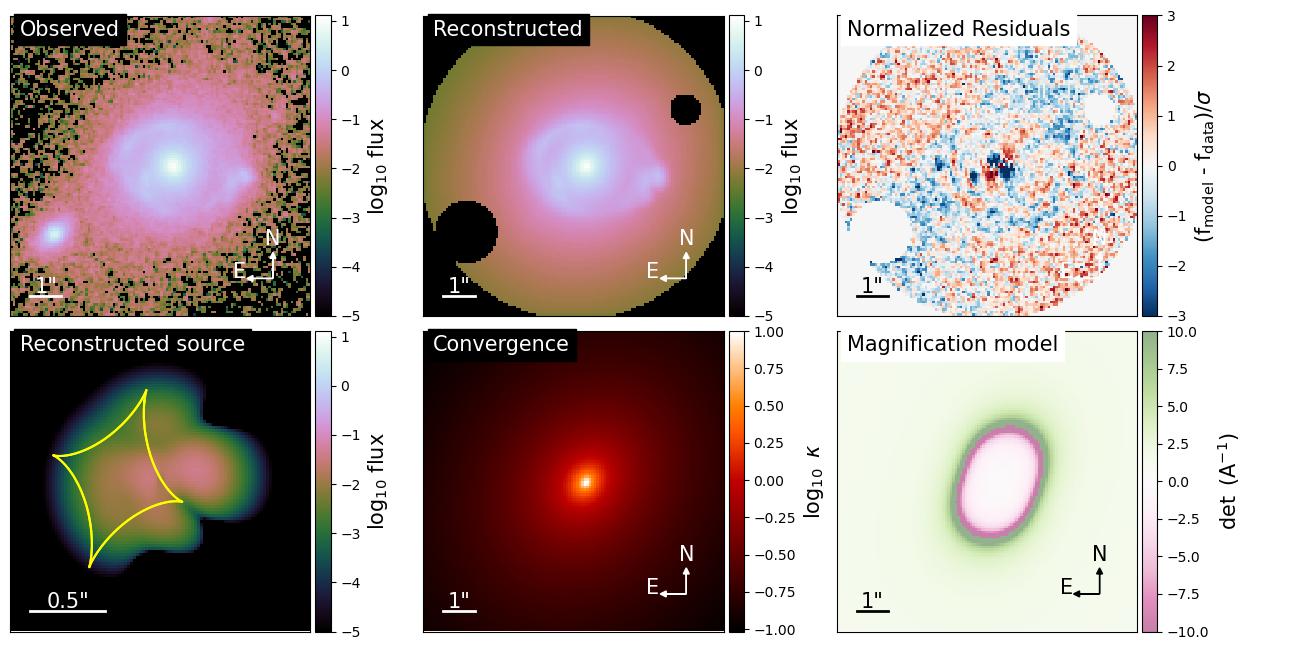

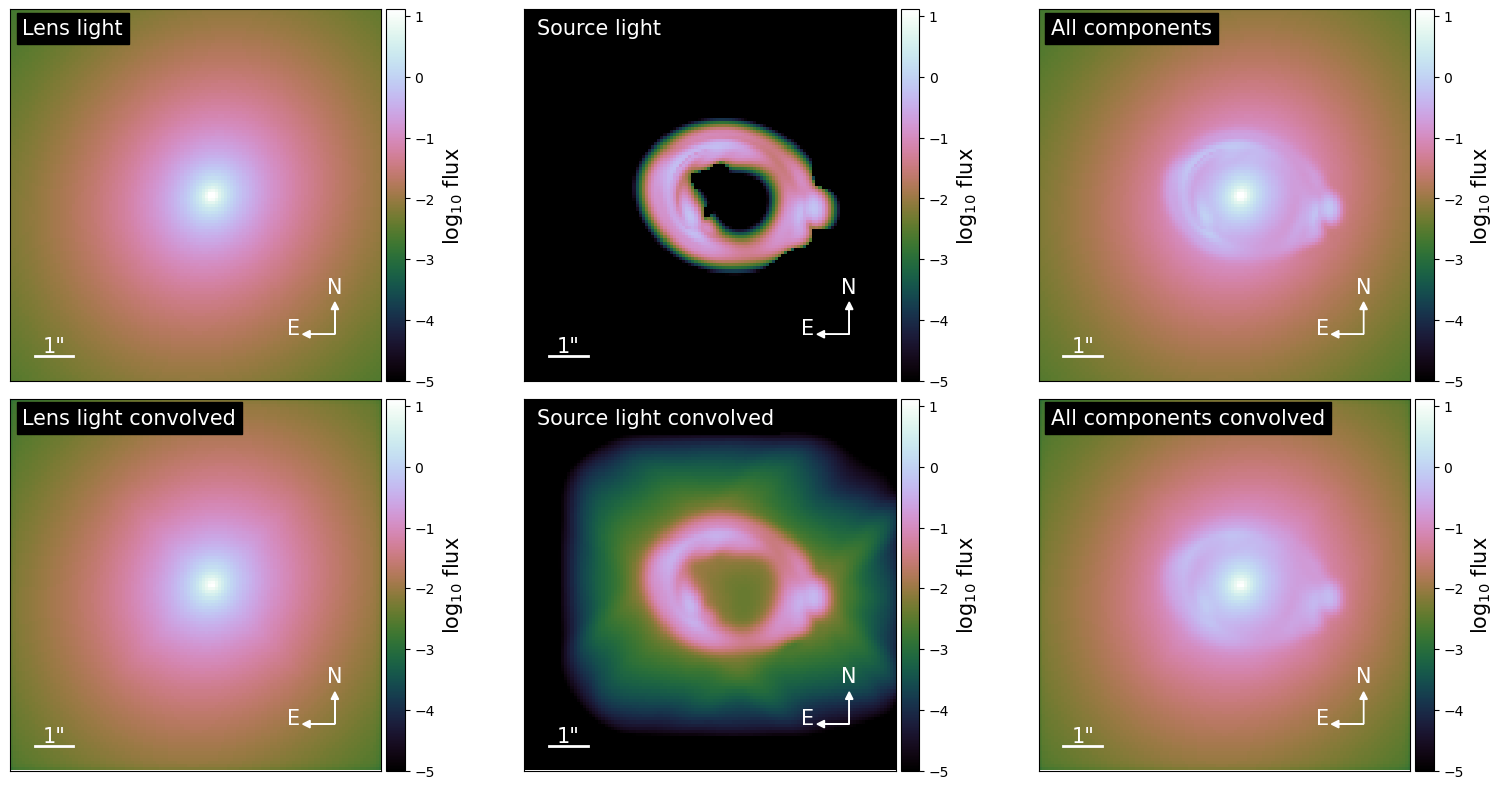

In [31]:
print(kwargs_result)
model_plot = ModelPlot(
    multi_band_list,
    kwargs_model,
    kwargs_result,
    arrow_size=0.02,
    cmap_string="cubehelix",
    image_likelihood_mask_list=kwargs_likelihood["image_likelihood_mask_list"],
)

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.data_plot(ax=axes[0, 0])
model_plot.model_plot(ax=axes[0, 1])
model_plot.normalized_residual_plot(ax=axes[0, 2], v_min=-3, v_max=3, cmap="RdBu_r")
model_plot.source_plot(
    ax=axes[1, 0],
    deltaPix_source=0.02,
    numPix=100,
    scale_size=0.5,
    with_caustics=True,
)
model_plot.convergence_plot(ax=axes[1, 1], v_max=1, cmap="gist_heat")
model_plot.magnification_plot(ax=axes[1, 2], cmap="PiYG")
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

model_plot.decomposition_plot(
    ax=axes[0, 0], text="Lens light", lens_light_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 0], text="Lens light convolved", lens_light_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 1], text="Source light", source_add=True, unconvolved=True
)
model_plot.decomposition_plot(
    ax=axes[1, 1], text="Source light convolved", source_add=True
)
model_plot.decomposition_plot(
    ax=axes[0, 2],
    text="All components",
    source_add=True,
    lens_light_add=True,
    unconvolved=True,
)
model_plot.decomposition_plot(
    ax=axes[1, 2],
    text="All components convolved",
    source_add=True,
    lens_light_add=True,
    point_source_add=True,
)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.05)
plt.show()